In [1]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('final_ultimate_log_replaced.csv')

In [2]:
df.head()

,hr_unit_artmp,hr_unit_hum,land_area,forest_area,growing_stock,forest_ratio,avg_growing_stock,u10_mean_ms,v10_mean_ms,wind_dir_deg,...,month_9,month_10,month_11,month_12,cntr_grnds_dstnc,frstn_grnds_dstnc,dspt_req_hr,relax_diff,fire_supesn_hr,wind_speed_mean
0,-1.0,39.0,1635,373,30500,22.81,81.77,2.943493,-1.980742,303.937485,...,0,0,0,0,1.609438,2.484907,5.509388,0.000000,7.277248,1.514662
1,5.0,60.0,1635,373,30500,22.81,81.77,1.894473,0.657474,250.860749,...,0,0,0,0,1.098612,1.609438,5.537334,0.000000,6.749931,1.100383
2,7.0,49.0,1635,373,30500,22.81,81.77,1.958302,-1.082838,298.940291,...,0,0,0,0,1.791759,2.302585,6.467699,0.000000,7.650169,1.174876
3,0.3,48.0,4931,3461,512610,70.18,148.11,2.946276,-2.642112,311.884583,...,0,0,0,0,1.098612,1.791759,6.361302,0.000000,7.653495,1.600889
4,-8.7,36.0,66075,51936,9313181,78.60,179.32,4.143709,1.113212,254.962483,...,0,0,0,1,2.397895,3.295837,6.774224,8.830689,9.638154,1.665939


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 파일 경로
CSV_PATH = "final_ultimate_log_replaced.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "fire_supesn_hr"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 모델에서 제외할 컬럼(있으면 제거)
EXCLUDE_COLS = {
    "total_time", "fire_supesn_hr", "relax_diff", "wind_speed_mean",
    TARGET  # 타깃은 당연히 피처에서 제외
}

# 숫자형 컬럼만 사용(원-핫 완료 가정) + 제외 컬럼 제거
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in EXCLUDE_COLS]

# 필요 시 누수 변수 제거 (새 데이터에 없으면 자동 무시)
LEAKY_COL = "ARRIVAL_DELAY_MIN_LOG"
if not INCLUDE_LEAKY and LEAKY_COL in feature_cols:
    feature_cols.remove(LEAKY_COL)

# 안전장치: 피처가 하나도 없으면 에러
if len(feature_cols) == 0:
    raise ValueError("선택된 피처가 없습니다. EXCLUDE_COLS 또는 전처리를 확인하세요.")

print(f"선택된 피처 수: {len(feature_cols)}")
print("제외된 컬럼(데이터에 존재했던 항목만):",
      sorted([c for c in EXCLUDE_COLS if c in df.columns]))

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")

행: 3,361, 열: 66

컬럼명:
 ['hr_unit_artmp', 'hr_unit_hum', 'land_area', 'forest_area', 'growing_stock', 'forest_ratio', 'avg_growing_stock', 'u10_mean_ms', 'v10_mean_ms', 'wind_dir_deg', 'tp_sum_mm', 'pev_sum_mm', 'impute_radius', 'ctpv_nm_gangwon', 'ctpv_nm_gyeonggi', 'ctpv_nm_gyeongnam', 'ctpv_nm_gyeongbuk', 'ctpv_nm_gwangju', 'ctpv_nm_daegu', 'ctpv_nm_daejeon', 'ctpv_nm_busan', 'ctpv_nm_seoul', 'ctpv_nm_sejong', 'ctpv_nm_ulsan', 'ctpv_nm_incheon', 'ctpv_nm_jeonnam', 'ctpv_nm_jeonbuk', 'ctpv_nm_jeju', 'ctpv_nm_chungnam', 'ctpv_nm_chungbuk', 'wndrct_brng_south', 'wndrct_brng_southeast', 'wndrct_brng_southwest', 'wndrct_brng_east', 'wndrct_brng_north', 'wndrct_brng_northeast', 'wndrct_brng_northwest', 'wndrct_brng_west', 'total_time', 'arrival_time_diff', 'dispatch_time_diff', 'golden_time_under_50min', 'is_night', 'wspd_bin_1', 'wspd_bin_2', 'wspd_bin_3', 'wspd_bin_4', 'wspd_bin_5', 'month_1', 'month_2']  ...


,hr_unit_artmp,hr_unit_hum,land_area,forest_area,growing_stock,forest_ratio,avg_growing_stock,u10_mean_ms,v10_mean_ms,wind_dir_deg,...,month_9,month_10,month_11,month_12,cntr_grnds_dstnc,frstn_grnds_dstnc,dspt_req_hr,relax_diff,fire_supesn_hr,wind_speed_mean
0,-1.0,39.0,1635,373,30500,22.81,81.77,2.943493,-1.980742,303.937485,...,0,0,0,0,1.609438,2.484907,5.509388,0.000000,7.277248,1.514662
1,5.0,60.0,1635,373,30500,22.81,81.77,1.894473,0.657474,250.860749,...,0,0,0,0,1.098612,1.609438,5.537334,0.000000,6.749931,1.100383
2,7.0,49.0,1635,373,30500,22.81,81.77,1.958302,-1.082838,298.940291,...,0,0,0,0,1.791759,2.302585,6.467699,0.000000,7.650169,1.174876
3,0.3,48.0,4931,3461,512610,70.18,148.11,2.946276,-2.642112,311.884583,...,0,0,0,0,1.098612,1.791759,6.361302,0.000000,7.653495,1.600889
4,-8.7,36.0,66075,51936,9313181,78.60,179.32,4.143709,1.113212,254.962483,...,0,0,0,1,2.397895,3.295837,6.774224,8.830689,9.638154,1.665939


선택된 피처 수: 62
제외된 컬럼(데이터에 존재했던 항목만): ['fire_supesn_hr', 'relax_diff', 'total_time', 'wind_speed_mean']

최종 데이터 크기: X=(3361, 62), y=(3361,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [5]:
def optimize_hyperparameters(X, y):
    """
    RandomForest 하이퍼파라미터 그리드 탐색 (5-fold, MSE 기준)
    ※ 회귀에서 'auto'는 비권장/오류 → ['sqrt','log2']만 사용
    """
    print("=== 1단계: 하이퍼파라미터 최적화 시작 ===")
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
    }

    gscv = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',  # RMSE를 바로 쓰려면 'neg_root_mean_squared_error'도 가능
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X, y)

    best_params = gscv.best_params_
    best_score_mse = -gscv.best_score_

    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_score_mse:,.4f} (RMSE={np.sqrt(best_score_mse):,.4f})")

    return best_params, gscv.best_estimator_

best_params, best_model = optimize_hyperparameters(X, y)

=== 1단계: 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

최적 하이퍼파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
최적 CV MSE: 1.0131 (RMSE=1.0065)


In [6]:
def train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5):
    """
    최적 파라미터 고정 + seed만 바꿔가며 10회 k-fold CV
    RMSE/MAE/R² 평균·표준편차를 저장
    """
    print(f"\n=== 2단계: {n_iterations}회 학습(k={k_folds}) ===")
    results = []
    models = []

    for i in range(n_iterations):
        print(f"\n--- {i+1}번째 모델 학습 ---")
        rf = RandomForestRegressor(**best_params, random_state=42+i, n_jobs=-1)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42+i)

        # MSE / R2 / MAE (sklearn은 neg_* 반환 → 부호 반전)
        mse_scores = -cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        rmse_scores = np.sqrt(mse_scores)
        r2_scores  = cross_val_score(rf, X, y, cv=kf, scoring='r2', n_jobs=-1)
        mae_scores = -cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

        result = {
            'iteration': i+1,
            'mse_mean': mse_scores.mean(), 'mse_std': mse_scores.std(),
            'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
            'r2_mean': r2_scores.mean(),     'r2_std': r2_scores.std(),
            'mae_mean': mae_scores.mean(),   'mae_std': mae_scores.std(),
            'mse_scores': mse_scores, 'rmse_scores': rmse_scores,
            'r2_scores': r2_scores,   'mae_scores': mae_scores
        }
        results.append(result)
        models.append(rf)

        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
        print(f"  MAE : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return results, models

results, models = train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5)


=== 2단계: 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 0.9897 ± 0.0370
  MAE : 0.7341 ± 0.0273
  R²  : 0.2174 ± 0.0215

--- 2번째 모델 학습 ---
  RMSE: 0.9823 ± 0.0506
  MAE : 0.7266 ± 0.0273
  R²  : 0.2296 ± 0.0343

--- 3번째 모델 학습 ---
  RMSE: 0.9857 ± 0.0477
  MAE : 0.7314 ± 0.0285
  R²  : 0.2232 ± 0.0217

--- 4번째 모델 학습 ---
  RMSE: 0.9867 ± 0.0189
  MAE : 0.7312 ± 0.0085
  R²  : 0.2223 ± 0.0179

--- 5번째 모델 학습 ---
  RMSE: 0.9843 ± 0.0632
  MAE : 0.7313 ± 0.0319
  R²  : 0.2255 ± 0.0257

--- 6번째 모델 학습 ---
  RMSE: 0.9866 ± 0.0342
  MAE : 0.7297 ± 0.0169
  R²  : 0.2211 ± 0.0298

--- 7번째 모델 학습 ---
  RMSE: 0.9863 ± 0.0405
  MAE : 0.7320 ± 0.0263
  R²  : 0.2225 ± 0.0084

--- 8번째 모델 학습 ---
  RMSE: 0.9857 ± 0.0170
  MAE : 0.7299 ± 0.0093
  R²  : 0.2242 ± 0.0246

--- 9번째 모델 학습 ---
  RMSE: 0.9886 ± 0.0351
  MAE : 0.7338 ± 0.0176
  R²  : 0.2172 ± 0.0285

--- 10번째 모델 학습 ---
  RMSE: 0.9871 ± 0.0452
  MAE : 0.7346 ± 0.0264
  R²  : 0.2201 ± 0.0127



=== 3단계: 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.9863 ± 0.0019
MAE  평균: 0.7315 ± 0.0023
R²   평균: 0.2223 ± 0.0035

최고 R² 모델: 2번째 (R²=0.2296)
최저 MSE 모델: 2번째 (MSE=0.9675, RMSE=0.9836)


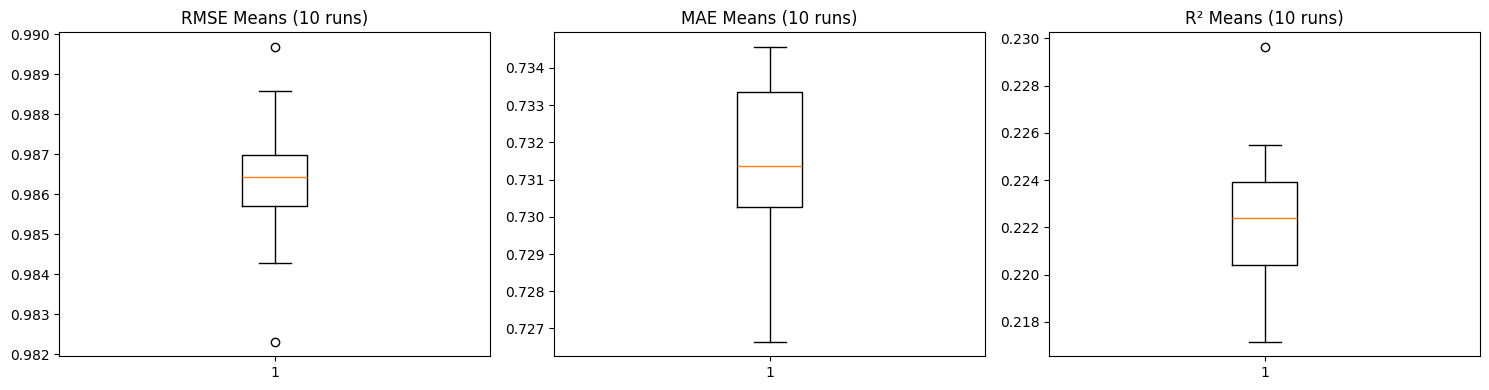

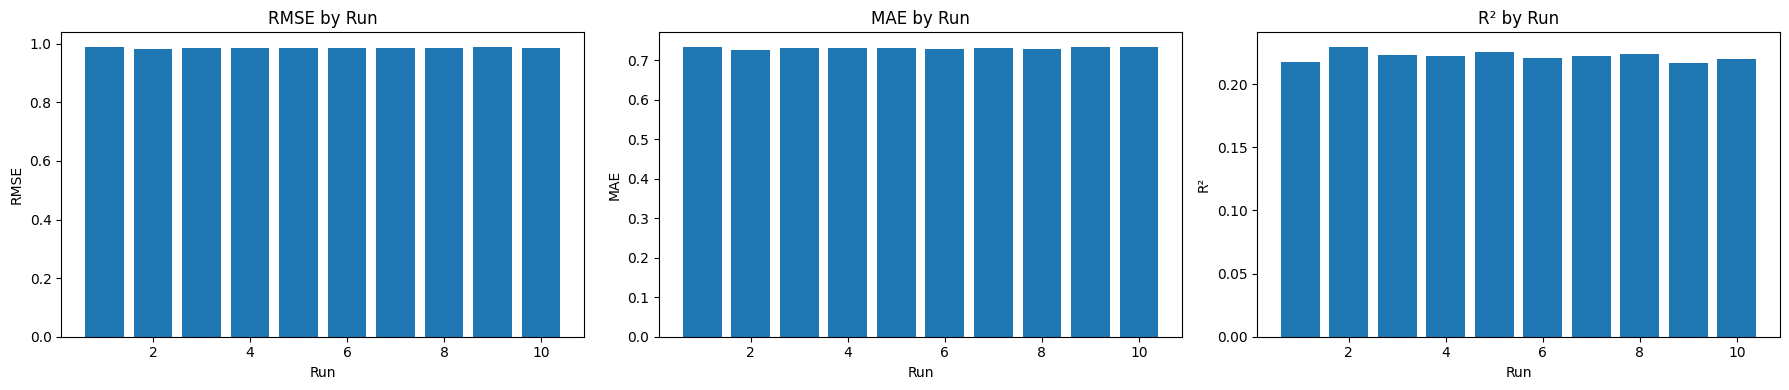


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.9651  0.8966 -0.9670
RMSE  0.9651  1.0000  0.8269 -0.9797
MAE   0.8966  0.8269  1.0000 -0.8548
R2   -0.9670 -0.9797 -0.8548  1.0000


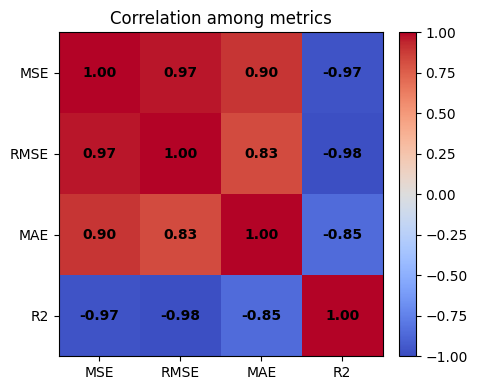

In [7]:
def analyze_results(results):
    print("\n=== 3단계: 결과 종합 및 분석 ===")
    rmse_means = [r['rmse_mean'] for r in results]
    mae_means  = [r['mae_mean']  for r in results]
    r2_means   = [r['r2_mean']   for r in results]
    mse_means  = [r['mse_mean']  for r in results]

    print(f"\n전체 {len(results)}개 모델 성능 요약:")
    print(f"RMSE 평균: {np.mean(rmse_means):.4f} ± {np.std(rmse_means):.4f}")
    print(f"MAE  평균: {np.mean(mae_means):.4f} ± {np.std(mae_means):.4f}")
    print(f"R²   평균: {np.mean(r2_means):.4f} ± {np.std(r2_means):.4f}")

    best_r2_idx  = int(np.argmax(r2_means))
    best_mse_idx = int(np.argmin(mse_means))
    print(f"\n최고 R² 모델: {best_r2_idx+1}번째 (R²={r2_means[best_r2_idx]:.4f})")
    print(f"최저 MSE 모델: {best_mse_idx+1}번째 (MSE={mse_means[best_mse_idx]:.4f}, RMSE={np.sqrt(mse_means[best_mse_idx]):.4f})")

    # --- Boxplot (분포)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].boxplot(rmse_means); axes[0].set_title('RMSE Means (10 runs)')
    axes[1].boxplot(mae_means);  axes[1].set_title('MAE Means (10 runs)')
    axes[2].boxplot(r2_means);   axes[2].set_title('R² Means (10 runs)')
    plt.tight_layout(); plt.show()

    # --- Bar plot (비교)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(range(1, len(results)+1), rmse_means); axes[0].set_title('RMSE by Run'); axes[0].set_xlabel('Run'); axes[0].set_ylabel('RMSE')
    axes[1].bar(range(1, len(results)+1), mae_means);  axes[1].set_title('MAE by Run');  axes[1].set_xlabel('Run'); axes[1].set_ylabel('MAE')
    axes[2].bar(range(1, len(results)+1), r2_means);   axes[2].set_title('R² by Run');   axes[2].set_xlabel('Run'); axes[2].set_ylabel('R²')
    plt.tight_layout(); plt.show()

    # --- 상관행렬
    corr_df = pd.DataFrame({
        'MSE': mse_means, 'RMSE': rmse_means, 'MAE': mae_means, 'R2': r2_means
    })
    corr = corr_df.corr()
    print("\n성능 지표 간 상관계수:\n", corr.round(4))

    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontweight='bold')
    plt.title('Correlation among metrics')
    plt.tight_layout(); plt.show()

    return best_r2_idx, best_mse_idx

best_r2_idx, best_mse_idx = analyze_results(results)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS별 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


=== 특성 중요도 분석 ===

상위 10개 특성 중요도:


,feature,importance
38,arrival_time_diff,0.087284
61,dspt_req_hr,0.085248
59,cntr_grnds_dstnc,0.056527
3,forest_area,0.056159
60,frstn_grnds_dstnc,0.052541
7,u10_mean_ms,0.050738
4,growing_stock,0.050281
11,pev_sum_mm,0.048508
5,forest_ratio,0.048458
2,land_area,0.047630


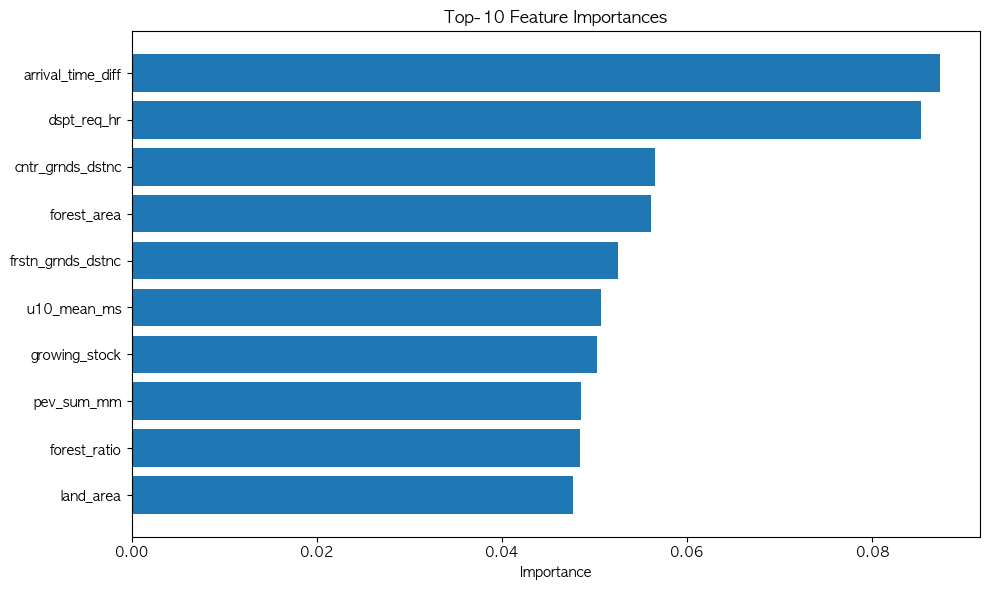

In [9]:
print("\n=== 특성 중요도 분석 ===")
# 최적 모델(best_model)로 전체 데이터 적합 후 중요도 확인
best_model.fit(X, y)
fi = pd.DataFrame({'feature': feature_cols, 'importance': best_model.feature_importances_}) \
        .sort_values('importance', ascending=False)

print("\n상위 10개 특성 중요도:")
display(fi.head(10))

# 시각화
plt.figure(figsize=(10,6))
top = fi.head(10)
plt.barh(range(len(top)), top['importance'])
plt.yticks(range(len(top)), top['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance'); plt.title('Top-10 Feature Importances')
plt.tight_layout(); plt.show()

In [10]:
# === best_model(RandomForest)로 바로 평가 (로그/원단위 모두) — 출력 단위: 분/시간 선택 ===
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------
# 설정
# -----------------------
TARGET_IS_LOG = True        # 타깃이 로그변환 컬럼이면 True (예: fire_supesn_hr_log 스케일)
TIME_UNIT     = "min"       # 'sec' | 'min' | 'hour'
SHOW_BOTH     = True        # 보조 단위(예: 분 선택 시 시간)도 함께 표시

assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."
assert 'best_model' in globals(), "GridSearchCV로 학습된 best_model(=best_estimator_)이 필요합니다."

X_np = np.asarray(X)
y_np = np.asarray(y, dtype=float)

# -----------------------
# 헬퍼
# -----------------------
def to_unit(v_sec, unit="sec"):
    if unit == "min":  return v_sec / 60.0
    if unit == "hour": return v_sec / 3600.0
    return v_sec

def unit_label(unit):
    return {"sec":"초", "min":"분", "hour":"시간"}[unit]

def hhmm(v_sec):
    v_sec = float(v_sec)
    h = int(v_sec // 3600)
    m = int((v_sec % 3600) // 60)
    return f"{h}h {m}m"

def show_with_both(name, v_sec):
    main_val = to_unit(v_sec, TIME_UNIT)
    s = f"{name}: {main_val:,.2f} {unit_label(TIME_UNIT)}"
    if SHOW_BOTH:
        other_unit = {"sec":"min", "min":"hour", "hour":"min"}[TIME_UNIT]
        other_val  = to_unit(v_sec, other_unit)
        s += f"  |  ({other_val:,.2f} {unit_label(other_unit)}, ~{hhmm(v_sec)})"
    return s

# -----------------------
# best_model로 예측 (로그 스케일에서 성능)
# -----------------------
y_pred_log = best_model.predict(X_np)
rmse_log   = float(np.sqrt(mean_squared_error(y_np, y_pred_log)))
mae_log    = float(mean_absolute_error(y_np, y_pred_log))
r2_log     = float(r2_score(y_np, y_pred_log))

print("=== (best_model) 학습데이터 기준 성능 — 로그 스케일 ===")
print(f"RMSE: {rmse_log:.4f}")
print(f"MAE : {mae_log:.4f}")
print(f"R²  : {r2_log:.4f}")

# -----------------------
# 원 단위(초)로 복원 후 통계/지표
# -----------------------
if TARGET_IS_LOG:
    y_true_sec = np.expm1(y_np)
    y_pred_sec = np.expm1(y_pred_log)
else:
    y_true_sec = y_np
    y_pred_sec = y_pred_log

mean_true    = float(np.mean(y_true_sec))
median_true  = float(np.median(y_true_sec))
std_true     = float(np.std(y_true_sec))
mean_pred    = float(np.mean(y_pred_sec))
median_pred  = float(np.median(y_pred_sec))

rmse_orig = float(np.sqrt(mean_squared_error(y_true_sec, y_pred_sec)))
mae_orig  = float(mean_absolute_error(y_true_sec, y_pred_sec))
r2_orig   = float(r2_score(y_true_sec, y_pred_sec))  # 역변환 후 R²는 참고용

print(f"\n=== 실제 종속변수 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("평균",     mean_true))
print(show_with_both("중앙값",   median_true))
print(show_with_both("표준편차", std_true))

print(f"\n=== 예측 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("예측 평균",    mean_pred))
print(show_with_both("예측 중앙값",  median_pred))
print(show_with_both("평균 차이(예측-실제)",   mean_pred - mean_true))
print(show_with_both("중앙값 차이(예측-실제)", median_pred - median_true))

print(f"\n=== 원 단위에서의 오차 지표 (참고) ===")
print(show_with_both("RMSE", rmse_orig))
print(show_with_both("MAE",  mae_orig))
print(f"R²  : {r2_orig:.4f}  (역변환 후 R²는 참고용)")


=== (best_model) 학습데이터 기준 성능 — 로그 스케일 ===
RMSE: 0.6606
MAE : 0.4759
R²  : 0.6520

=== 실제 종속변수 통계 (표시 단위 → 분) ===
평균: 189.73 분  |  (3.16 시간, ~3h 9m)
중앙값: 72.52 분  |  (1.21 시간, ~1h 12m)
표준편차: 585.21 분  |  (9.75 시간, ~9h 45m)

=== 예측 통계 (표시 단위 → 분) ===
예측 평균: 92.62 분  |  (1.54 시간, ~1h 32m)
예측 중앙값: 78.13 분  |  (1.30 시간, ~1h 18m)
평균 차이(예측-실제): -97.12 분  |  (-1.62 시간, ~-2h 22m)
중앙값 차이(예측-실제): 5.61 분  |  (0.09 시간, ~0h 5m)

=== 원 단위에서의 오차 지표 (참고) ===
RMSE: 556.46 분  |  (9.27 시간, ~9h 16m)
MAE: 119.88 분  |  (2.00 시간, ~1h 59m)
R²  : 0.0958  (역변환 후 R²는 참고용)
